# Data Cleaning and Feature Selection

In [ ]:
!pip install zoofs

  Preparing metadata (setup.py) ... done
  Created wheel for zoofs: filename=zoofs-0.1.26-py3-none-any.whl size=23602 sha256=6e1cec9da75fe9e2354529c429e1e455abef1901bbfc667daa68ce8bbe3ec043
  Stored in directory: /root/.cache/pip/wheels/c5/47/90/d0547288297679ffb3e38d6d5b700dab7bc0314cf677051b77
Successfully built zoofs


In [ ]:
!pip install mealpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from mealpy.swarm_based.HHO import OriginalHHO
from zoofs import HarrisHawkOptimization
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/IoT_Intrusion.csv')

# Display the first few rows of the dataframe
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [ ]:
df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22256 entries, 0 to 22255
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flow_duration    22256 non-null  float64
 1   Header_Length    22256 non-null  float64
 2   Protocol Type    22256 non-null  float64
 3   Duration         22256 non-null  float64
 4   Rate             22256 non-null  float64
 5   Srate            22256 non-null  float64
 6   Drate            22256 non-null  float64
 7   fin_flag_number  22256 non-null  int64  
 8   syn_flag_number  22256 non-null  int64  
 9   rst_flag_number  22256 non-null  int64  
 10  psh_flag_number  22256 non-null  int64  
 11  ack_flag_number  22256 non-null  int64  
 12  ece_flag_number  22256 non-null  int64  
 13  cwr_flag_number  22256 non-null  int64  
 14  ack_count        22256 non-null  float64
 15  syn_count        22256 non-null  float64
 16  fin_count        22256 non-null  float64
 17  urg_count   

In [ ]:
df.shape

(22256, 47)

In [ ]:
df1 = df.sample(n=10000, random_state=42)

In [ ]:
df1.shape

(10000, 47)

In [ ]:
label_column = df1['label']

print(label_column.head())
print(label_column.tail())

15245            DDoS-ICMP_Flood
6352              DDoS-UDP_Flood
5908              DDoS-TCP_Flood
14061         Mirai-greeth_flood
17127    DDoS-ICMP_Fragmentation
Name: label, dtype: object
12186       DDoS-UDP_Flood
17781      DDoS-ICMP_Flood
2655        DDoS-UDP_Flood
9592      DDoS-RSTFINFlood
12907    DDoS-PSHACK_Flood
Name: label, dtype: object


In [ ]:
df1.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
12186,0.174087,29105.00,17.00,64.0,3319.363145,3319.363145,0.0,0,0,0,...,0.00000,50.00,83123465.49,9.5,10.000000,0.00000,0.000000,0.00,141.55,DDoS-UDP_Flood
17781,0.000000,0.54,1.05,64.0,1.941560,1.941560,0.0,0,0,0,...,0.59827,42.12,83132156.55,9.5,9.188072,0.84699,2.205671,0.17,141.55,DDoS-ICMP_Flood
2655,0.028551,11059.50,17.00,64.0,6035.924162,6035.924162,0.0,0,0,0,...,0.00000,50.00,83106613.12,9.5,10.000000,0.00000,0.000000,0.00,141.55,DDoS-UDP_Flood
9592,0.000000,54.00,6.00,64.0,4.924225,4.924225,0.0,1,0,1,...,0.00000,54.00,83349388.90,9.5,10.392305,0.00000,0.000000,0.00,141.55,DDoS-RSTFINFlood
12907,0.000000,54.00,6.00,64.0,6.012253,6.012253,0.0,0,0,0,...,0.00000,54.00,83318220.07,9.5,10.392305,0.00000,0.000000,0.00,141.55,DDoS-PSHACK_Flood


In [ ]:
# Handling missing values: drop any rows where 'label' is missing
df1.dropna(subset=['label'], inplace=True)

In [ ]:
# Encode categorical labels
label_encoder = LabelEncoder()
df1['label'] = label_encoder.fit_transform(df1['label'])

In [ ]:
# Separate features and target
X = df1.drop(columns=['label'])
y = df1['label']

In [ ]:
# Stratify split if each class has at least two instances, otherwise, do simple random split
class_counts = y.value_counts()
if all(class_counts >= 2):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
# Convert scaled arrays back to DataFrame, preserving column names
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_valid = pd.DataFrame(X_valid_scaled, index=X_valid.index, columns=X_valid.columns)

In [ ]:
pd.set_option('display.max_rows', 100)

# Display the first 100 rows of the DataFrame
print(df1.head(100))

       flow_duration  Header_Length  Protocol Type  Duration          Rate  \
15245       0.000000           0.00           1.00     64.00    144.403778   
6352        0.084212       29623.50          17.00     64.00   9164.376552   
5908        0.000000          54.00           6.00     64.00      0.712637   
14061       0.000000           0.00          47.00     64.00      0.400958   
17127       0.000000           0.00           0.99     63.36      1.486245   
14202       0.042539           2.32           1.05     65.73      0.953537   
21707       0.000000           0.00           1.00     65.91      0.503036   
11598       0.000000          54.00           6.00     64.00     39.540556   
259         5.056994         108.00           6.00     64.00      0.395492   
7784        0.000000           0.00           1.00     64.00     47.842498   
20594       0.000000          54.00           6.00     64.00      1.595166   
20339       0.000000           0.00           1.00     65.91    

#HHO( Harris' Hawk Optimization)

In [ ]:
epoch_accuracies = []

# Define your fitness function
def fitness(solution):
    # Select features based on binary solution encoding
    selected_features_indices = np.where(solution > 0.5)[0]
    if len(selected_features_indices) == 0:
        return 1e10  # Penalty for empty feature set
    # Subset the features based on the selected indices
    X_selected = X.iloc[:, selected_features_indices]
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3)
    # Initialize and fit the model
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    # Make predictions and calculate accuracy
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    epoch_accuracies.append(acc)
    return -acc  # Because HHO is a minimization algorithm

In [ ]:
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar

In [ ]:
# Define the bounds directly as tuples of arrays for lower and upper bounds.
bounds = FloatVar(np.zeros(X.shape[1]), np.ones(X.shape[1]))

# Create the problem dictionary.
problem_definition = {
    'obj_func': fitness,
    'bounds': bounds,
    'minmax': 'min',  # Define if it's a minimization or maximization problem.
}

In [ ]:
# Initialize the Problem object using the dictionary.
problem_obj = Problem(**problem_definition)

# Initialize the HHO optimizer using the problem object.
# It appears the HHO class has been updated to use a problem dict directly rather than an object.
optimizer = OriginalHHO(epoch=10, pop_size=30)

# Solve the optimization problem.
best_agent = optimizer.solve(problem_definition)

INFO:mealpy.swarm_based.HHO.OriginalHHO:Solving single objective optimization problem.
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 1, Current best: -0.9896666666666667, Global best: -0.9896666666666667, Runtime: 34.42332 seconds
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 2, Current best: -0.9903333333333333, Global best: -0.9903333333333333, Runtime: 40.12630 seconds
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 3, Current best: -0.9903333333333333, Global best: -0.9903333333333333, Runtime: 50.86596 seconds
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 4, Current best: -0.9903333333333333, Global best: -0.9903333333333333, Runtime: 46.94892 seconds
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 5, Current best: -0.9903333333333333, Global best: -0.9903333333333333, Runtime: 46.88423 seconds
INFO:mealpy.swarm_based.HHO.OriginalHHO:>>>Problem: P, Epoch: 6, Current best: -0.9903333333333333, Global best: 

In [ ]:
print(dir(best_agent))

['ID', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compare_duplicate', 'copy', 'get_better_solution', 'id', 'increase', 'is_better_than', 'is_duplicate', 'kwargs', 'set_kwargs', 'solution', 'target', 'update', 'update_agent']


In [ ]:
# Extract the best solution and its corresponding fitness (or target) from the Agent object
best_solution = best_agent.solution
best_fitness = best_agent.target

accuracy = best_fitness
print(f"Accuracy: {accuracy}")

Accuracy: Objectives: [-0.99166667], Fitness: -0.9916666666666667


In [ ]:
# After optimization, to get the best features
selected_features_indices = np.where(best_solution > 0.5)[0]
selected_features = X.columns[selected_features_indices]  # This assumes X is a DataFrame

print("Selected features by HHO:", selected_features)

Selected features by HHO: Index(['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT',
       'Variance'],
      dtype='object')


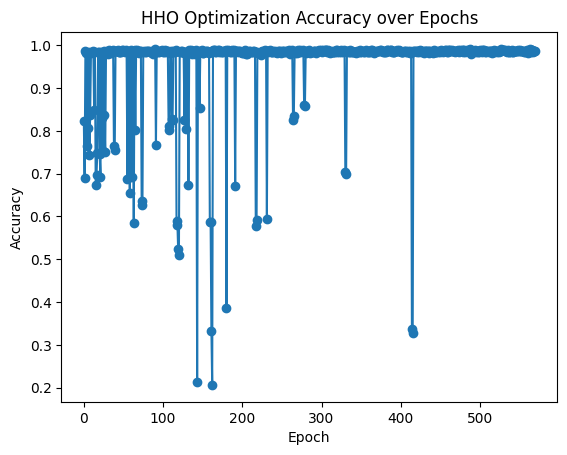

In [ ]:
# Plot the accuracies over epochs
plt.plot(epoch_accuracies, marker='o')
plt.title('HHO Optimization Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Cuckoo Search Algorithm

In [ ]:
import numpy as np

def levy_flights(beta, dimensions):
    # Generates step sizes from a Levy distribution
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
             (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    return np.random.normal(0, sigma, size=(dimensions,))

def get_fitness(solution):
    # Placeholder for your fitness function, e.g., classification accuracy
    # Implement your method to evaluate the solution here
    return np.random.rand()

def cuckoo_search(n_nests=25, max_generations=100, pa=0.25, beta=1.5):
    dimensions = df1.shape[1]  # Assuming df1 is your feature set
    nests = np.random.rand(n_nests, dimensions)
    fitness = np.array([get_fitness(nest) for nest in nests])

    for gen in range(max_generations):
        # Get a cuckoo randomly by levy flights
        cuckoo_idx = np.random.randint(n_nests)
        cuckoo = nests[cuckoo_idx] + levy_flights(beta, dimensions)
        cuckoo = np.clip(cuckoo, 0, 1)  # Ensure the cuckoo is within valid range
        cuckoo_fitness = get_fitness(cuckoo)

        # Choose a nest randomly to replace
        nest_idx = np.random.randint(n_nests)
        if cuckoo_fitness > fitness[nest_idx]:
            nests[nest_idx] = cuckoo
            fitness[nest_idx] = cuckoo_fitness

        # Abandon a fraction pa of worse nests and build new ones
        worst_nests_idx = np.argsort(fitness)[:int(pa * n_nests)]
        nests[worst_nests_idx] = np.random.rand(len(worst_nests_idx), dimensions)
        fitness[worst_nests_idx] = np.array([get_fitness(nest) for nest in nests[worst_nests_idx]])

        # Keep the best solution found
        best_nest_idx = np.argmax(fitness)
        best_nest = nests[best_nest_idx]
        best_fitness = fitness[best_nest_idx]

        print(f"Generation {gen+1}: Best Fitness {best_fitness}")

    # Determine the selected features based on a threshold
    selected_features = np.where(best_nest > 0.5)[0]
    print(f"Selected Features: {selected_features}")
    return best_nest, best_fitness, selected_features

# Assuming df1 is defined, call cuckoo_search
best_nest, best_fitness, selected_features = cuckoo_search()


Generation 1: Best Fitness 0.921814546227795
Generation 2: Best Fitness 0.921814546227795
Generation 3: Best Fitness 0.921814546227795
Generation 4: Best Fitness 0.9882436991980816
Generation 5: Best Fitness 0.9882436991980816
Generation 6: Best Fitness 0.9882436991980816
Generation 7: Best Fitness 0.9882436991980816
Generation 8: Best Fitness 0.9882436991980816
Generation 9: Best Fitness 0.9882436991980816
Generation 10: Best Fitness 0.9882436991980816
Generation 11: Best Fitness 0.9882436991980816
Generation 12: Best Fitness 0.9882436991980816
Generation 13: Best Fitness 0.9882436991980816
Generation 14: Best Fitness 0.9882436991980816
Generation 15: Best Fitness 0.9882436991980816
Generation 16: Best Fitness 0.9882436991980816
Generation 17: Best Fitness 0.9882436991980816
Generation 18: Best Fitness 0.9882436991980816
Generation 19: Best Fitness 0.9882436991980816
Generation 20: Best Fitness 0.9882436991980816
Generation 21: Best Fitness 0.9882436991980816
Generation 22: Best Fitne

<ipython-input-35-b060109dee51>:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
<ipython-input-35-b060109dee51>:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)


In [ ]:
# best_solution, best_fitness = cuckoo_search()
# print("Best solution:", best_solution)
# print("Best fitness:", best_fitness)
best_nest, best_fitness, selected_features = cuckoo_search()

Generation 1: Best Fitness 0.987621828773726
Generation 2: Best Fitness 0.987621828773726
Generation 3: Best Fitness 0.9910846023454285
Generation 4: Best Fitness 0.9910846023454285
Generation 5: Best Fitness 0.9910846023454285
Generation 6: Best Fitness 0.9910846023454285
Generation 7: Best Fitness 0.9910846023454285
Generation 8: Best Fitness 0.9910846023454285
Generation 9: Best Fitness 0.9910846023454285
Generation 10: Best Fitness 0.991992246381154
Generation 11: Best Fitness 0.991992246381154
Generation 12: Best Fitness 0.991992246381154
Generation 13: Best Fitness 0.991992246381154
Generation 14: Best Fitness 0.991992246381154
Generation 15: Best Fitness 0.991992246381154
Generation 16: Best Fitness 0.991992246381154
Generation 17: Best Fitness 0.991992246381154
Generation 18: Best Fitness 0.991992246381154
Generation 19: Best Fitness 0.991992246381154
Generation 20: Best Fitness 0.991992246381154
Generation 21: Best Fitness 0.991992246381154
Generation 22: Best Fitness 0.991992

<ipython-input-35-b060109dee51>:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
<ipython-input-35-b060109dee51>:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)


In [ ]:
import pandas as pd

# Assuming df1 is your DataFrame and selected_features are the indices you obtained
column_names = df1.columns[selected_features]

print("Selected Feature Names:")
print(column_names.tolist())  # Print as list


Selected Feature Names:
['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


In [ ]:
selected_features_hho = ['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number','psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count','urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT','Variance']
selected_features_cuckoo = ['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

In [ ]:
set_hho = set(selected_features_hho)
set_cuckoo = set(selected_features_cuckoo)

common_features = set_hho.intersection(set_cuckoo)
unique_hho = set_hho.difference(set_cuckoo)
unique_cuckoo = set_cuckoo.difference(set_hho)


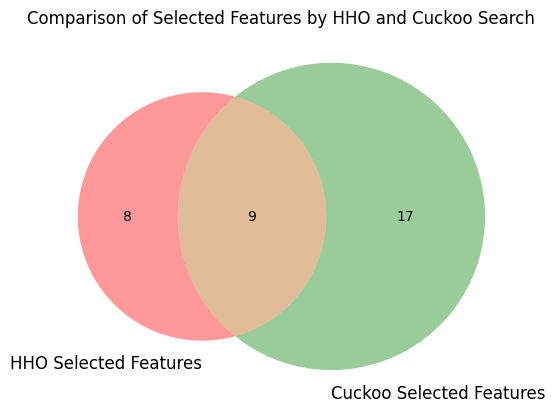

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# Create a Venn diagram
venn2([set_hho, set_cuckoo], ('HHO Selected Features', 'Cuckoo Selected Features'))
plt.title("Comparison of Selected Features by HHO and Cuckoo Search")
plt.show()

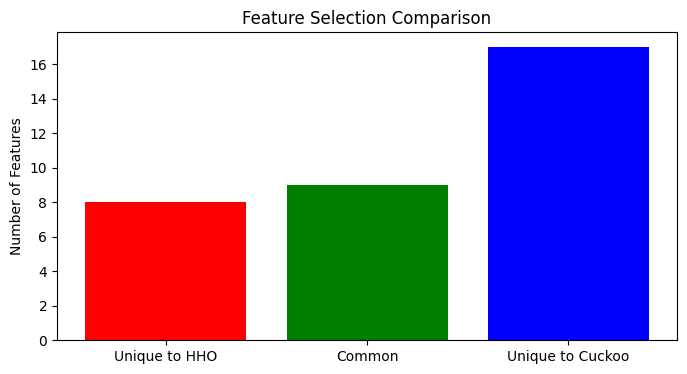

In [ ]:
counts = [len(unique_hho), len(common_features), len(unique_cuckoo)]
features_set = ['Unique to HHO', 'Common', 'Unique to Cuckoo']

plt.figure(figsize=(8, 4))
plt.bar(features_set, counts, color=['red', 'green', 'blue'])
plt.title('Feature Selection Comparison')
plt.ylabel('Number of Features')
plt.show()


In [ ]:
print("Common Features Selected by Both Algorithms:", common_features)
print("Features Unique to HHO:", unique_hho)
print("Features Unique to Cuckoo Search:", unique_cuckoo)

Common Features Selected by Both Algorithms: {'syn_count', 'Tot sum', 'ack_count', 'urg_count', 'Variance', 'HTTP', 'Header_Length', 'DNS', 'rst_flag_number'}
Features Unique to HHO: {'SMTP', 'SSH', 'ack_flag_number', 'flow_duration', 'IAT', 'UDP', 'psh_flag_number', 'fin_flag_number'}
Features Unique to Cuckoo Search: {'Magnitue', 'Covariance', 'TCP', 'Protocol Type', 'Telnet', 'Max', 'ARP', 'Radius', 'Duration', 'Drate', 'Rate', 'DHCP', 'HTTPS', 'cwr_flag_number', 'LLC', 'Weight', 'syn_flag_number'}


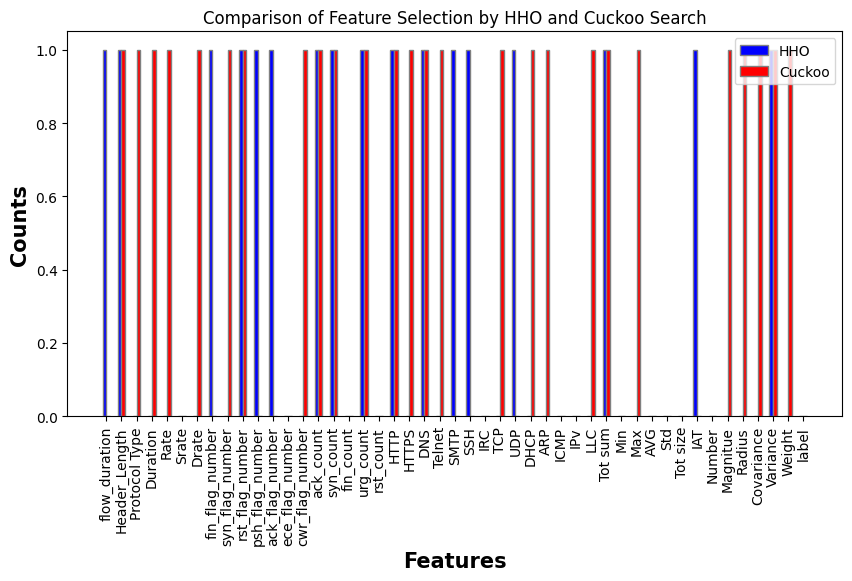

In [ ]:
# Sample selected features from both algorithms
selected_features_hho = ['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number','psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count','urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT','Variance']
selected_features_cuckoo = ['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

# List all features from df1
all_features = df.columns.tolist()
# Initialize counts
feature_counts = {feature: {'HHO': 0, 'Cuckoo': 0} for feature in all_features}

# Count for HHO
for feature in selected_features_hho:
    if feature in feature_counts:
        feature_counts[feature]['HHO'] += 1

# Count for Cuckoo
for feature in selected_features_cuckoo:
    if feature in feature_counts:
        feature_counts[feature]['Cuckoo'] += 1
import matplotlib.pyplot as plt
import numpy as np

# Extracting data for plotting
features = list(feature_counts.keys())
hho_counts = [feature_counts[feature]['HHO'] for feature in features]
cuckoo_counts = [feature_counts[feature]['Cuckoo'] for feature in features]

# Set position of bar on X axis
r1 = np.arange(len(features))
r2 = [x + 0.25 for x in r1]

# Make the plot
plt.figure(figsize=(10, 5))
plt.bar(r1, hho_counts, color='b', width=0.25, edgecolor='grey', label='HHO')
plt.bar(r2, cuckoo_counts, color='r', width=0.25, edgecolor='grey', label='Cuckoo')

# Add xticks on the middle of the group bars
plt.xlabel('Features', fontweight='bold', fontsize=15)
plt.ylabel('Counts', fontweight='bold', fontsize=15)
plt.xticks([r + 0.125 for r in range(len(features))], features, rotation=90)

plt.title('Comparison of Feature Selection by HHO and Cuckoo Search')
plt.legend()

# Create legend & Show graphic
plt.show()


In [ ]:
features = df.columns.tolist()
selected_features_hho = ['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number','psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count','urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT','Variance']
selected_features_cuckoo = ['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

In [ ]:
# Count occurrence of each feature selection by HHO and Cuckoo
hho_selection = [1 if feature in selected_features_hho else 0 for feature in features]
cuckoo_selection = [1 if feature in selected_features_cuckoo else 0 for feature in features]


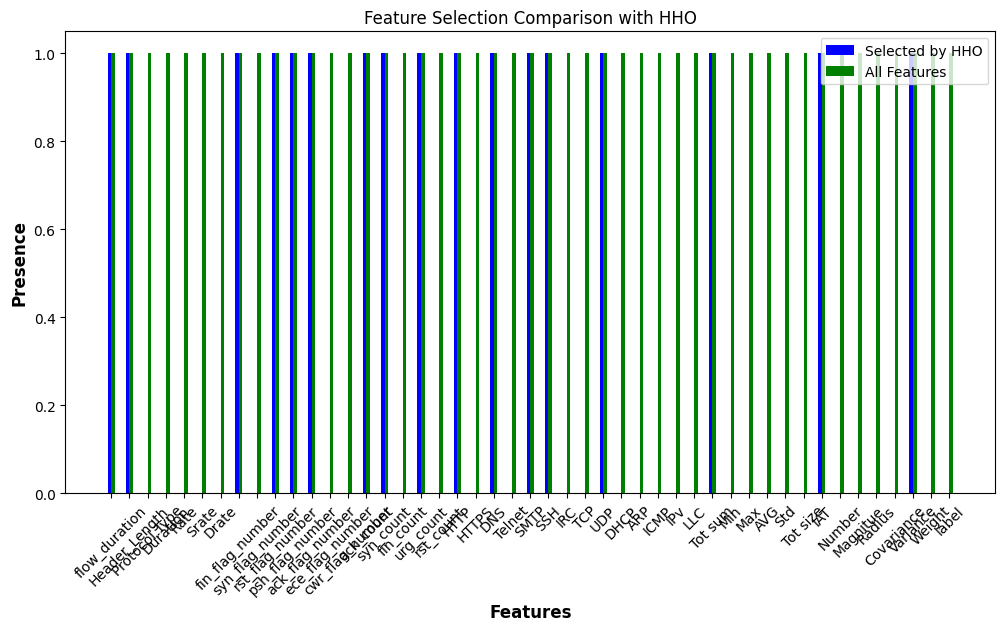

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set position of bars on X axis
x = np.arange(len(features))

# Make the plot for HHO
plt.figure(figsize=(12, 6))
plt.bar(x - 0.1, hho_selection, color='b', width=0.2, label='Selected by HHO')
plt.bar(x + 0.1, np.ones(len(features)), color='g', width=0.2, label='All Features')

# Add xticks on the middle of the group bars
plt.xlabel('Features', fontweight='bold', fontsize=12)
plt.ylabel('Presence', fontweight='bold', fontsize=12)
plt.xticks(x, features, rotation=45)
plt.title('Feature Selection Comparison with HHO')
plt.legend()

# Show graphic
plt.show()

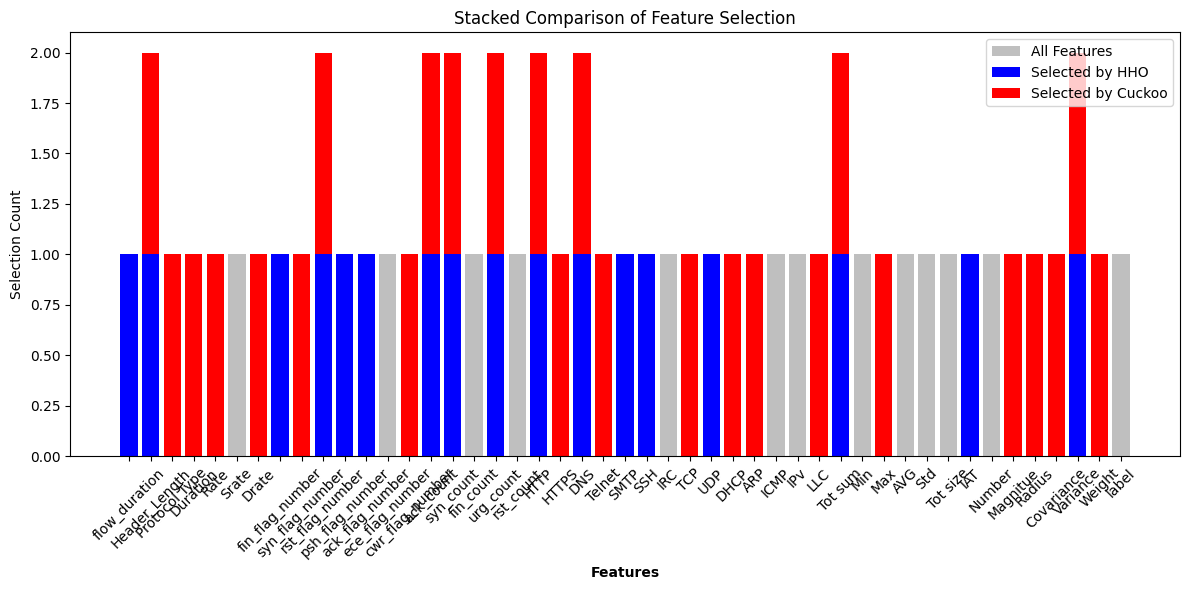

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

selected_features_hho = ['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number','psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count','urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT','Variance']
selected_features_cuckoo = ['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
# Sample data
features = df.columns.tolist()
hho_selection = [1 if feature in selected_features_hho else 0 for feature in features]
cuckoo_selection = [1 if feature in selected_features_cuckoo else 0 for feature in features]
total_features = [1] * len(features)  # Since every feature is present

# Stacking selections over total features
plt.figure(figsize=(12, 6))
plt.bar(features, total_features, label='All Features', color='gray', alpha=0.5)
plt.bar(features, hho_selection, label='Selected by HHO', color='blue')
plt.bar(features, cuckoo_selection, bottom=hho_selection, label='Selected by Cuckoo', color='red')

# Adding labels and titles
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Selection Count')
plt.title('Stacked Comparison of Feature Selection')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


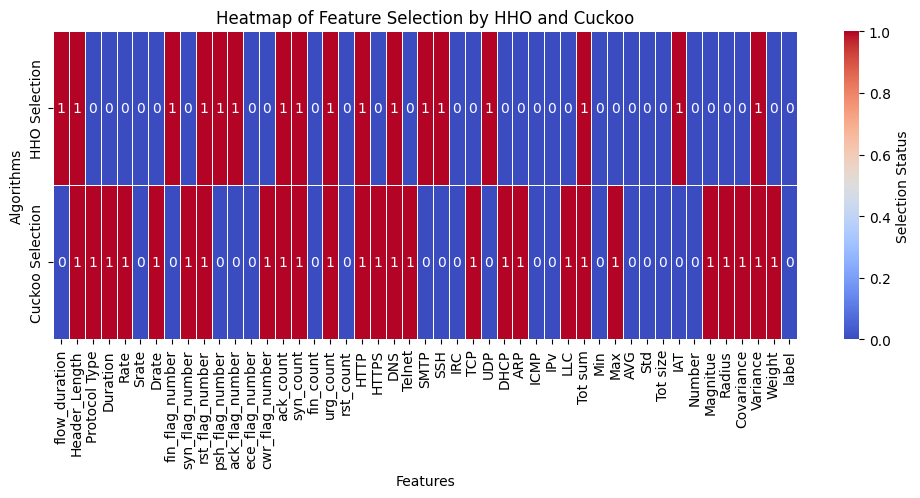

In [ ]:
import seaborn as sns
import pandas as pd

# Prepare data for the heatmap
selected_features_hho = ['flow_duration', 'Header_Length', 'fin_flag_number', 'rst_flag_number','psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count','urg_count', 'HTTP', 'DNS', 'SMTP', 'SSH', 'UDP', 'Tot sum', 'IAT','Variance']
selected_features_cuckoo = ['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'syn_flag_number', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'TCP', 'DHCP', 'ARP', 'LLC', 'Tot sum', 'Max', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
data = {
    'Feature': features,
    'HHO Selection': [1 if feature in selected_features_hho else 0 for feature in features],
    'Cuckoo Selection': [1 if feature in selected_features_cuckoo else 0 for feature in features]
}
df = pd.DataFrame(data).set_index('Feature')

# Create a heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(df.T, cmap='coolwarm', cbar_kws={'label': 'Selection Status'}, linewidths=.5, annot=True)
plt.title('Heatmap of Feature Selection by HHO and Cuckoo')
plt.xlabel('Features')
plt.ylabel('Algorithms')

# Display the plot
plt.show()
